In [13]:
import sys
sys.path.append("v2_Assignment_Codes")  # Add the folder to the search path

#load data
from v2_data import get_fixed_data
from PriceProcess import price_model
from WindProcess import wind_model
from utils import generate_time_series,generate_experiment_series

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyomo.environ import *
from mdp import check_feasibility,sim_MDP_exp, sim_MDP, generate_scenarios

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
data = get_fixed_data()
T = data['num_timeslots']

In [15]:
# ensure we always use the same time series for all tasks and experiments
prices,winds = generate_experiment_series()

# Task 4

In [16]:
import random

np.random.seed(42)
random.seed(42)

E = 20

## Evaluate the policies 

In [17]:
from mdp import dummy_policy, sim_optimal_in_hindsight, MultiStagePolicy, ADPPolicy, sample_representative_state_pairs, ValueFunction,backward_value_approx


### Dummy Policy

In [18]:
mean_dummy, costs_dummy = sim_MDP(E,dummy_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [00:00<00:00, 13202.09it/s]


### Optimal-in-hindsight solution

In [19]:
mean_oih, costs_oih = sim_optimal_in_hindsight(E,winds,prices)

Simulating OIH: 100%|██████████| 20/20 [00:01<00:00, 14.60it/s]


### Stochastic programming policy for 4 configurations

In [20]:
results = np.zeros((4,E))

multi_state_policy = MultiStagePolicy(L=2,k=500)
_, results[0,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=3,k=18)
_, results[1,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=4,k=6)
_, results[2,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=7,k=2)
_, results[3,:] = sim_MDP(E,multi_state_policy,winds,prices)


Simulating MDP: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


### Expected value policy

In [21]:
from utils import generate_time_series_from_initial_state

def solve_multi_stage_model(t_start,scenarios,a_set,scenario_probs,price,wind,h_0,e_on_0):
    T = price.shape[0] #Ø WAS HERE: Changed from len(scenarios). Note 'scenarios' is now an unused input
    S = price.shape[1] #Ø WAS HERE: Changed from len(scenarios[-1])
    
    # Create a model
    model = ConcreteModel()
    # Declare indexed variable for the price
    model.p_grid = Var(range(T),range(S), within=NonNegativeReals,name='p_grid')
    model.e_h2p = Var(range(T),range(S), within=NonNegativeReals,bounds=(0,data['h2p_max_rate']),name='e_h2p')
    model.e_p2h = Var(range(T),range(S), within=NonNegativeReals,bounds=(0,data['p2h_max_rate']),name='e_p2h')
    model.e_on = Var(range(-1,T-1),range(S), within=Binary,name='e_on',initialize=0)

    model.h = Var(range(T),range(S), within=NonNegativeReals,bounds=(0,data['hydrogen_capacity']),name='h')

    vars = [model.p_grid,model.e_h2p,model.e_p2h,model.e_on,model.h]

    model.non_anticipativity = ConstraintList()
    for var in vars:
        for t in range(T-1):
            #for s in range(S):
                # find s index in a_set[t]
                # s_relative = s % len(a_set[t])
                # for s_prime in a_set[t][s_relative]: 
                #     model.non_anticipativity.add(var[t, s] == var[t, s_prime])
            for a_subset in a_set[t]:
                sprime = a_subset[0]
                for s in a_subset:
                    model.non_anticipativity.add(var[t, s] == var[t, sprime])
                


    # Objective function
    def objective_rule(model):
        return sum(scenario_probs[s]*(price[t,s] * model.p_grid[t,s] + data['electrolyzer_cost']*model.e_on[t-1,s]) for s in range(S) for t in range(T))
    
    model.profit = Objective(rule=objective_rule, sense=minimize)

    model.DemandConstraint = Constraint(range(T),range(S), rule=lambda model, t,s: model.p_grid[t,s] + wind[t,s] + data['conversion_h2p']*model.e_h2p[t,s] - model.e_p2h[t,s] >= data['demand_schedule'][t_start+t])

    # contraints
    model.h_contraint = Constraint(range(T-1), range(S), rule=lambda model, t, s: model.h[t+1, s] == model.h[t, s] + data['conversion_p2h']*model.e_p2h[t, s] - model.e_h2p[t, s])

    model.p2h_constraint = Constraint(range(T), range(S), rule=lambda model, t, s:  model.e_h2p[t, s] <= model.h[t, s])
    model.p2h_constraint2 = Constraint(range(T),range(S),rule=lambda model,t,s: data['conversion_h2p']*model.e_h2p[t, s] <= data['h2p_max_rate'])
    
    model.conversion_contraint = Constraint(range(T), range(S), rule=lambda model, t, s:  data['conversion_p2h']*model.e_p2h[t, s] <= data['p2h_max_rate']*model.e_on[t-1, s])

    model.tank_start = Constraint(range(S), rule=lambda model, s: model.h[0, s] == h_0)

    model.electrolyser_start = Constraint(range(S), rule=lambda model, s: model.e_on[-1, s] == e_on_0)

    # Create a solver
    solver = SolverFactory('gurobi') 

    # Solve the model
    results = solver.solve(model, tee=False)
    #print(f"S= {S}, T={T}, n_variables={len(list(model.component_objects(Var)))}")
    return results,model



class ExpectedValuePolicy:
    #Ø WAS HERE
    
    
    def __init__(self, L=4,k=3):
        self.L = L
        self.k = k

    def __call__(self, t, h, e_on, wind, wind_previous, price, price_previous,data):
        L = min(self.L, data['num_timeslots'] - t) - 1

        #old_scenarios, old_scenario_probs = generate_scenarios(wind, price, wind_previous, price_previous, L, k=self.k)

        scenarios = [generate_time_series_from_initial_state(wind, price, wind_previous, price_previous, L+1) for _ in range(self.k)]
        #NOTE: L+1... not sure why
    
        price_matrix = np.array([prices for prices, _ in scenarios]).T
        wind_matrix = np.array([winds for _, winds in scenarios]).T
        
        #expected value, yielding a single scenario
        price_matrix = np.mean(price_matrix, axis=1, keepdims=True) #along sample axis
        wind_matrix = np.mean(wind_matrix, axis=1, keepdims=True)
        
        a_set = [[[0]] for _ in range(L+1)] #at each time there is only one scenario --> only one equivalence class --> the set of indeces of elements of that class is [0]
        scenario_probs = [[1]]
        
        #note second input 'scenarios' is unused
        results, model = solve_multi_stage_model(t, _, a_set, scenario_probs[-1], price_matrix, wind_matrix, h, e_on)

        if not results.solver.termination_condition == TerminationCondition.optimal:
            raise ValueError(f"Optimal solution not found t={t}")
        
        #get info on e_on
        
        e_on = value(model.e_on[0, 0]) if t < data['num_timeslots'] - 1 else 0
        e_p2h = value(model.e_p2h[0, 0])
        e_h2p = value(model.e_h2p[0, 0])
        p_grid = value(model.p_grid[0, 0])
        return e_on, e_p2h, e_h2p, p_grid

In [22]:
expected_value_policy = ExpectedValuePolicy(L=24,k=1000)
mean_ev, costs_ev = sim_MDP(E,expected_value_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


### ADP Policy

In [23]:
# fit value function
state_pairs = sample_representative_state_pairs(100)
V = backward_value_approx(ValueFunction(data['num_timeslots'],7),state_pairs,100,data)

t=23
2680.6452947185626
65.71406903328194
t=22
2501.9929034060806
43.30710941399329
t=21
2237.0402486006087
82.98896782114193
t=20
2210.055620229106
30.85227521890459
t=19
2093.89079057404
80.8124608844039
t=18
2498.3808058309874
42.62158012239535
t=17
2557.6086138184487
40.20309441031469
t=16
3049.9975555200717
41.36899334149618
t=15
3413.2094686206337
23.787672035602814
t=14
3410.522927331134
66.94344629147426
t=13
3059.674683018122
150.52687663418482
t=12
2537.596066419629
186.4992105725195
t=11
2334.1055950358436
251.89578894745358
t=10
2089.434065501441
366.68352561751055
t=9
3556.5685159076224
712.7320660961706
t=8
5282.759432850638
802.32132000681
t=7
6581.026030114897
642.412408712343
t=6
9371.474513451845
1069.0162721561735
t=5
10391.2325387449
1130.1318724369428
t=4
9588.092329364888
1059.534885772856
t=3
8246.141079473926
303.80901160904955
t=2
6569.948416749863
735.213553372806
t=1
5063.476628277114
124.27362673245612
t=0
1770.4794377732178
25.885847716648897


In [24]:
# evaluate policy
adp_policy = ADPPolicy(V, data)
mean_adp, costs_adp = sim_MDP(E,adp_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


In [25]:
import os
import pickle

# Ensure the "results" folder exists
os.makedirs("results", exist_ok=True)

# Load existing results if the file exists
results_file = "results/results_data.pkl"
if os.path.exists(results_file):
    with open(results_file, "rb") as file:
        results_data = pickle.load(file)
else:
    results_data = {}

# Prepare the data to save (override or add new values)
optional_values = {
    "mean_dummy": mean_dummy if 'mean_dummy' in locals() else None,
    "costs_dummy": costs_dummy if 'costs_dummy' in locals() else None,
    "mean_oih": mean_oih if 'mean_oih' in locals() else None,
    "costs_oih": costs_oih if 'costs_oih' in locals() else None,
    "mean_ev": mean_ev if 'mean_ev' in locals() else None,
    "costs_ev": costs_ev if 'costs_ev' in locals() else None,
    "mean_adp": mean_adp if 'mean_adp' in locals() else None,
    "costs_adp": costs_adp if 'costs_adp' in locals() else None,
    "results": results if 'results' in locals() else None,
    "data": data if 'data' in locals() else None,
    "prices": prices if 'prices' in locals() else None,
    "winds": winds if 'winds' in locals() else None,
    "state_pairs": state_pairs if 'state_pairs' in locals() else None
}

# Filter out None values
filtered_values = {key: value for key, value in optional_values.items() if value is not None}

# Update the results data
results_data.update(filtered_values)

# Save the updated data to the file
with open(results_file, "wb") as file:
    pickle.dump(results_data, file)

print(f"Results saved to '{results_file}'")

Results saved to 'results/results_data.pkl'


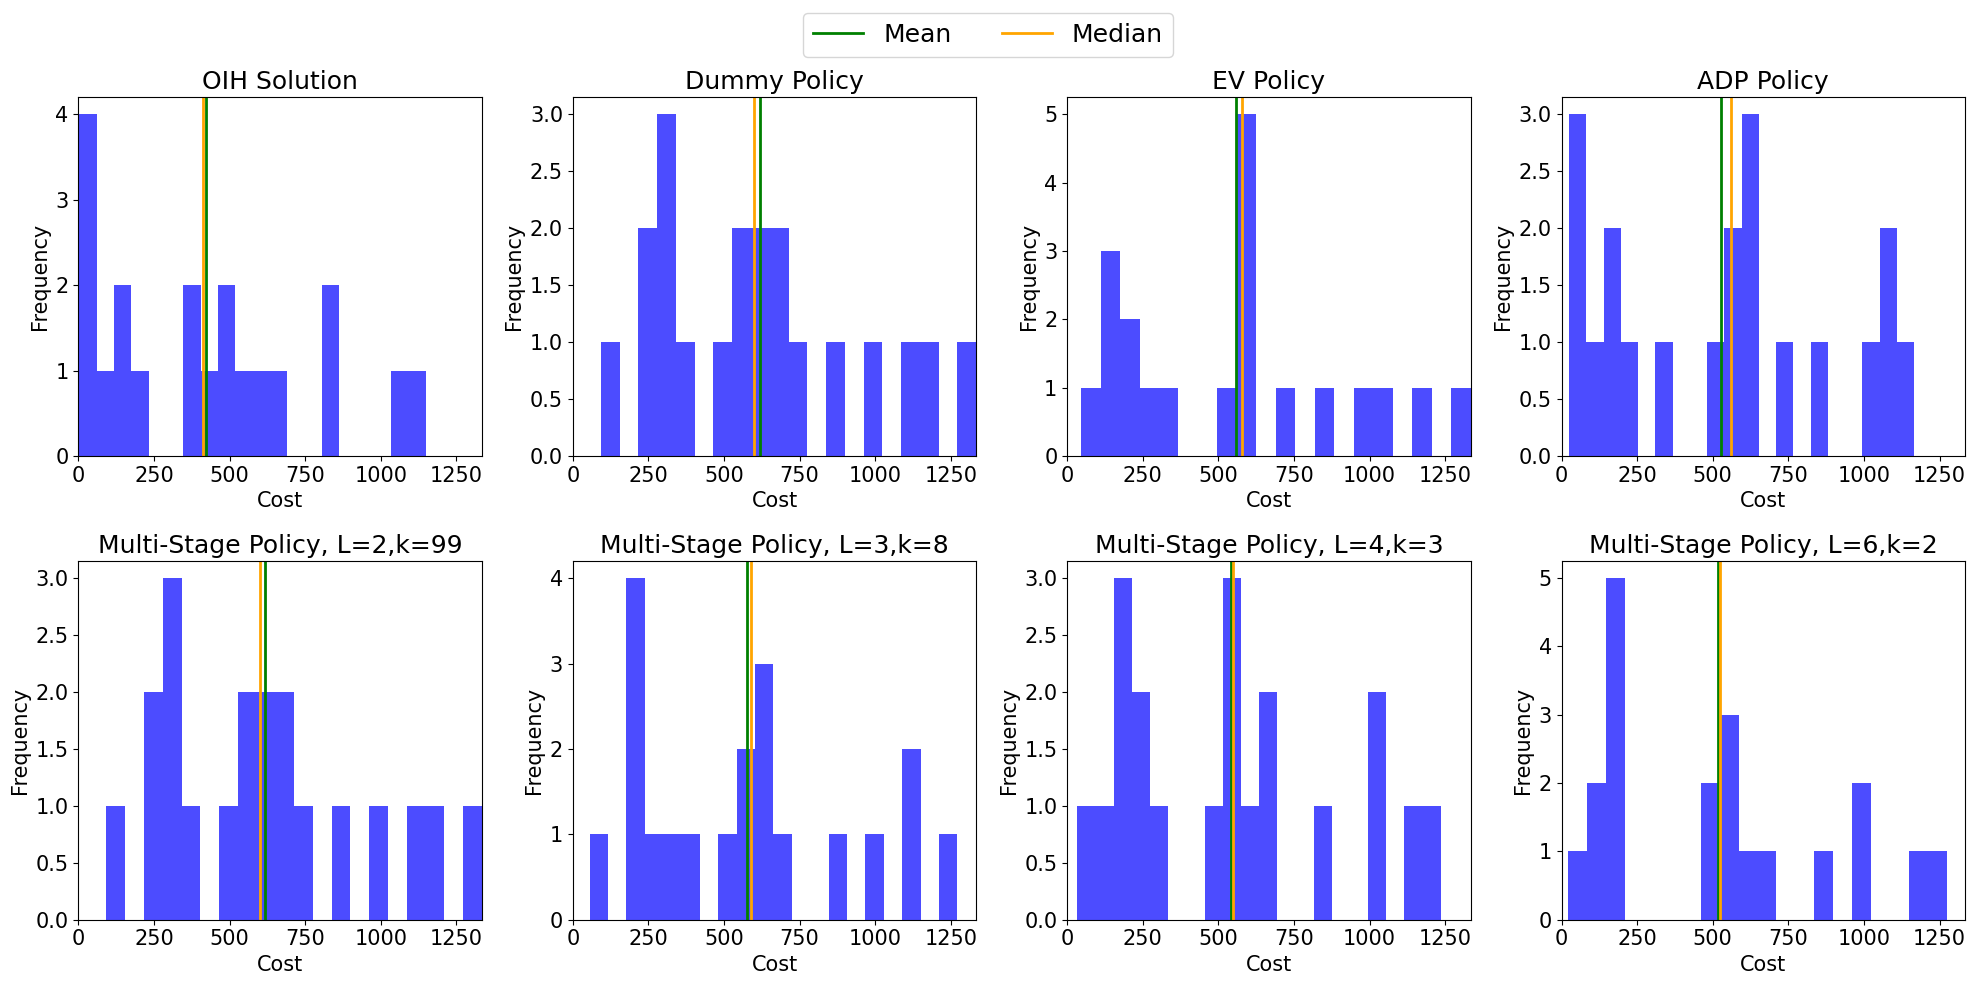

In [26]:
import pickle

# Load the results data from the file
with open("results/results_data.pkl", "rb") as file:
    results_data = pickle.load(file)

# Extract the necessary data
costs_dummy = results_data["costs_dummy"]
costs_oih = results_data["costs_oih"]
costs_ev = results_data["costs_ev"]
costs_adp = results_data["costs_adp"]
results = results_data["results"]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Define a common range for the x-axis
common_xlim = (0, max(max(costs_dummy), max(costs_oih), max(costs_ev), max(costs_adp), results.max()))

# Define consistent colors for histograms and lines
hist_color = 'blue'
mean_color = 'green'
median_color = 'orange'

# First row: Dummy, OIH, EV, and ADP policies
for i, (costs, title) in enumerate(zip(
    [costs_oih, costs_dummy, costs_ev, costs_adp],
    ["OIH Solution", "Dummy Policy", "EV Policy", "ADP Policy"]
)):
    axes[0, i].hist(costs, bins=20, color=hist_color, alpha=0.7)
    axes[0, i].axvline(np.mean(costs), color=mean_color, linewidth=2, label='Mean')
    axes[0, i].axvline(np.median(costs), color=median_color, linewidth=2, label='Median')
    axes[0, i].set_title(title)
    axes[0, i].set_xlabel("Cost")
    axes[0, i].set_ylabel("Frequency")
    axes[0, i].set_xlim(common_xlim)

config = ["L=2,k=99", "L=3,k=8", "L=4,k=3", "L=6,k=2"]

# Second row: Multi-state policies for 4 configurations
for i in range(4):
    axes[1, i].hist(results[i, :], bins=20, color=hist_color, alpha=0.7)
    axes[1, i].axvline(np.mean(results[i, :]), color=mean_color, linewidth=2, label='Mean')
    axes[1, i].axvline(np.median(results[i, :]), color=median_color, linewidth=2, label='Median')
    axes[1, i].set_title(f"Multi-Stage Policy, {config[i]}")
    axes[1, i].set_xlabel("Cost")
    axes[1, i].set_ylabel("Frequency")
    axes[1, i].set_xlim(common_xlim)

# Add a common legend
handles = [
    plt.Line2D([0], [0], color=mean_color, linewidth=2, label='Mean'),
    plt.Line2D([0], [0], color=median_color, linewidth=2, label='Median')
]
fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=18)
plt.tight_layout(rect=[0, 0.00, 1, 0.95])  # Adjust layout to make space for the legend
plt.savefig("figures/policy_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
methods = {
    "Dummy Policy": costs_dummy,
    "OIH Policy": costs_oih,
    "EV Policy": costs_ev,
    "ADP Policy": costs_adp,
    "Multi-State Policy (L=2, k=99)": results[0, :],
    "Multi-State Policy (L=3, k=8)": results[1, :],
    "Multi-State Policy (L=4, k=3)": results[2, :],
    "Multi-State Policy (L=6, k=2)": results[3, :]
}

for method, costs in methods.items():
    mean = np.mean(costs)
    std = np.std(costs)
    print(f"{method}: Mean = {mean:.2f}, Std = {std:.2f}")
    

print("------ ordered by mean cost -------")
# Sort the methods by their mean cost
sorted_methods = sorted(methods.items(), key=lambda x: np.mean(x[1]))

# Print the sorted methods with their mean and standard deviation
for method, costs in sorted_methods:
    mean = np.mean(costs)
    std = np.std(costs)
    print(f"{method}: Mean = {mean:.2f}, Std = {std:.2f}")

Dummy Policy: Mean = 618.46, Std = 331.41
OIH Policy: Mean = 421.44, Std = 342.30
EV Policy: Mean = 557.04, Std = 361.15
ADP Policy: Mean = 527.53, Std = 367.18
Multi-State Policy (L=2, k=99): Mean = 618.46, Std = 331.41
Multi-State Policy (L=3, k=8): Mean = 577.13, Std = 347.92
Multi-State Policy (L=4, k=3): Mean = 542.69, Std = 351.98
Multi-State Policy (L=6, k=2): Mean = 518.38, Std = 375.60
------ ordered by mean cost -------
OIH Policy: Mean = 421.44, Std = 342.30
Multi-State Policy (L=6, k=2): Mean = 518.38, Std = 375.60
ADP Policy: Mean = 527.53, Std = 367.18
Multi-State Policy (L=4, k=3): Mean = 542.69, Std = 351.98
EV Policy: Mean = 557.04, Std = 361.15
Multi-State Policy (L=3, k=8): Mean = 577.13, Std = 347.92
Multi-State Policy (L=2, k=99): Mean = 618.46, Std = 331.41
Dummy Policy: Mean = 618.46, Std = 331.41
